# Lecture 8: Application of Math/Stats/Code Pt. 2
## 11/07/2022

### Table Of Contents
* [Recap](#recap)
* [Ordinary Least Squares](#Ordinary-Least-Squares)
* [Regularization](#regularization)
    * [Ridge](#ridge)
    * [LASSO](#lasso)
     * [Gradient Descent](#gradient-descent)
    * [Visualizing Ridge and Lasso](#visualizing-ridge-and-lasso)
    * [Regularization and Bias Variance](#regularization-and-bias-variance)
    * [Lambda](#lambda)
    * [Validation on Lambda](#validation-on-lambda)
* [Exercises](#exercises)

In [21]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from plotting import ridgeRegularizationDemo, lassoRegularizationDemo
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

![alt text](fit_graphs.png "Fit Graphs")

> Bias/Variance is one way to understand Overfitting and Underfitting 


If we look at the first model, the points seem to follow some sort of curve, but our predictor is linear (not very complicated) and *unable to fit all the points* no matter how we wiggle it. We have chosen a model which is not complex enough to accurately capture all the information from our data set. 

In the last model, the predictor is super complex and adjusts based on every point. In this case, the model changes too much based on the data and isn't considering the 'big picture'. This model is fitting too much to the minor jitters. 

**High bias/Low Variance ~ underfitting**

**Low bias/High Variance ~ overfitting**

**Goldilocks - porridge**


Summary: We try to fiddle with bias/variance to get better models. Variance is important! because otherwise we only are building a model for our train not our normal dataset.

<sub> Bias-Variance error decomposition only works for convex loss functions (especially L2): https://www.textbook.ds100.org/ch/11/gradient_convexity.html</sub>

<a id='bv-tradeoff'></a>
# Bias-Variance Tradeoff

When making this tradeoff we do it by proxy -- using various metrics:

Today we'll perform **model evaluation**, where we'll judge how our linear regression models actually perform. Last week, we talked about **loss functions**, a function that describes a numerical value for how far your model is from the true values.

Today we will use:
$$\text{Mean Squared Error: } \frac{1}{n}\sum_{i=1}^n \left(y_i - \hat{f}(x_i)\right)^2$$

In this loss function, $y_i$ is a scalar, and $x_i$ is a $p$ dimensional vector, because there are $p$ features. This loss is called **mean squared error**, or **MSE**.

(i.e. if we have x=1, y=2, but our model says $\hat{f}(x_{1})=3$. Then the MSE is $(2-3)^2$.

<a id='the-tradeoff'></a>
## The Tradeoff

We are trying to minimize **expected error**, or the average **MSE** over all datasets. It turns out (with some advanced probability gymnastics), that:

$$\text{Mean Squared Error} = \text{Noise Variance} + \text{Bias}^2 + \text{Variance}$$

Note that $\text{Noise Variance}$ is constant: we assume there is some noise, and $\text{moise variance}$ is simply a value that describes how noisy your dataset will be on average. This is often also called "irreducible noise", as it is literally irreducible, we cannot avoid this. 

Furthermore, notice that the equation above is the sum of (squared) bias and variance. Thus there is a literal tradeoff between these two, since decreasing one increases the other. This defines what is known as the **bias variance tradeoff**. 

![alt text](BiasVarianceTradeoff.png "Bias Variance Tradeoff")

<sub style=''><p style='font-size:5pt;color:gray;text-align:right'>source:http://scott.fortmann-roe.com/docs/BiasVariance.html</p></sub>

**Why does this happen?**

At some point, as we decrease **bias**, instead of getting closer to the **true model** $h$, we go past and try to fit to the $\epsilon$ (noise) that is part of our current dataset. This is equivalent to making our model more noisy, or **overfit** on our dataset, which means that over all datasets, it has more **variance**.

**Questions for understanding**:
> 1. Where does underfitting and overfitting lie in the graph above? How do they relate to bias and variance?
> 2. Why is low variance important in models?

<a id='polynonmial-regression'></a>
## Polynomial Regression

Let's revisit the polynomial problem that we have discussed.

In this case, if our model has degree $d$, we have $d + 1$ features: $x = [x^0, x^1, ..., x^d]$. Now, we have a linear model with $d + 1$ features:

$$\hat{f}(x) = \sum_{i=0}^{d} a_i x^i$$

Model complexity in this case is the degree of the polynomial. As we saw last week, as $d$ increases, model complexity increases. The model gets better, but then gets erratic. This directly corresponds to the bias-variance graph above.

<a id='Ordinary-Least-Squares'></a>
# Ordinary Least Squares

Assume we have a dataset with **n** rows and **d** columns. Therefore, we will create the following model:

$$ y_i = \beta_0 + \beta_1x_{i1} + \dots + \beta_dx_{id} + \epsilon_i$$

$$for \space\space i = 1, ..., n$$

We can then stack these equations together and write them in matrix form:

$$ y = X\beta + \epsilon$$

Where:

$$ y = \begin{bmatrix} y_1\\ y_2\\ y_3\\ \vdots \\ y_n \end{bmatrix}$$

$$ X = \begin{bmatrix}
1&x_{11}&\dots&x_{1d}\\
1&x_{21}&\dots&x_{2d}\\
\vdots&\vdots&\ddots&\vdots\\
1&x_{n1}&\dots&x_{nd}\\
\end{bmatrix}$$

$$ \beta = \begin{bmatrix} \beta_0\\ \beta_1\\ \beta_2\\ \vdots \\ \beta_d \end{bmatrix}$$

And our error term $\epsilon$ is a vector in $\mathbb{R}^n$ that adds "noise" to our linear relationship.

Now that we have our data, we want to find the values of the vector $\beta$ that help us predict $y$ the best. In other words, we want to find the weights that we place on each column (or feature) of our data $X$, that minimize the difference between our actual values of $y$ and our predicted values $\hat{y}$.

One method to find our optimal weights (or coefficients) $\beta$ is known as Ordinary Least Squares (OLS). There are a number of assumptions necessary for OLS, but for the purposes of this notebook we can just assume that all assumptions are met.

<img src='linear_regression.png' width=400, height=600>

We can use OLS to minimize the sum of squared residuals. The solution to OLS is given by the equation: <br>
$$ \hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty$$ <br>
where $$\hat{\beta}_{OLS}$$ is the vector of the coefficients of each feature.

(If you're interested in how we derived this equation, you can find it at the end of this lesson.)

It turns out that the inverse in the equation above is sometimes hard or even impossible to compute (what would be some cases where it's impossible?). As a result, even though linear regression has a closed form solution, sometimes an algorithm like gradient descent (covered later) is used to find the optimal values of $\beta$.

### Derivation of Ordinary Least Squares


***Before we jump into OLS, a little bit of notation:***

Let:

$$ A = \begin{bmatrix} 3\\ -4\\ 5\end{bmatrix}$$

Then the L1 Norm of A is:

$$ \Vert A \Vert_1 = |3| + |-4| + |5| = 12$$

And the L2 Norm Squared of A is:

$$ \Vert A \Vert_2^2 = A^TA = (3)^2 + (-4)^2 + (5)^2 = 50$$

---

We can use OLS to minimize the sum of squared residuals:

$$\hat{\beta}_{OLS} = \underset{\beta}{\operatorname{argmin}} \Vert X\beta - y\Vert_2^2$$

Now how do we minimize this expression? Let us define our objective, [or cost function](https://stats.stackexchange.com/questions/179026/objective-function-cost-function-loss-function-are-they-the-same-thing), as:

$$ L(\beta) = \sum_{i=1}^{n}(y_i - x_i^T\beta)^2 = \Vert X\beta - y\Vert_2^2$$

First just rewrite this expression and FOIL.

$$ L(\beta) = (X\beta - y)^T(X\beta - y)$$

$$ = (X\beta)^T(X\beta) - (X\beta)^Ty - y^TX\beta + y^Ty $$

$$ = \beta^TX^TX\beta - 2\beta^TX^Ty + y^Ty$$

It can be proven that our objective function $L(\beta)$ is convex. This means that any critical point is a global minimum. So throwback to AP Calculus, what can we do?

$$ \nabla_\beta L(\beta) = \nabla_\beta (\beta^TX^TX\beta - 2\beta^TX^Ty + y^Ty)$$

$$ = \nabla_\beta(\beta^TX^TX\beta) - 2\nabla_\beta(\beta^TX^Ty) + \nabla_\beta(y^Ty)$$

$$ = 2X^TX\beta - 2X^Ty = 0$$

Thus,

$$ X^TX\hat{\beta}_{OLS} = X^Ty$$

$$ \hat{\beta}_{OLS} = (X^TX)^{-1}X^Ty$$

<a id='regularization'></a>
# Regularization

We talked about **validation** as a means of combating overfitting. However, this is not the only method to combat overfitting. Another method to do so is to add *regularization* terms to our loss function. **Regularization** basically penalizes complexity in our models. This allows us to add explanatory variables to our model without worrying as much about overfitting. Here's what our ordinary least squares model looks like with a regularization term:

$$\hat{\boldsymbol{\theta}} = \arg\!\min_\theta \sum_{i=1}^n (y_i - f_\boldsymbol{\theta}(x_i))^2 + \lambda R(\boldsymbol{\theta})$$

We've written the model a little differently here, but the first term is the same as the ordinary least squares regression model you learned last week. This time it's just generalized to any function of $x$ where $\theta$ is a list of parameters, or weights on our explanatory variables, such as coefficients to a polynomial. We're minimizing a loss function to find the best coefficients for our model. 

The second term is the **regularization** term. The $\lambda$ parameter in front of it dictates how much we care about our regularization term – the higher $\lambda$ is, the more we penalize large weights, and the more the regularization makes our weights deviate from OLS. 

**Question**: What happens when $\lambda = 0$?

So, what is $R(\theta)$ in the equation? There are a variety of different regularization functions that could take its place, but today, we'll just talk about the two most common types of functions: **ridge regression** and **LASSO regression**.


$$\begin{align}\text{ Ridge (L2 Norm)}: &\  R(\boldsymbol{\theta}) = \|\theta\|_2^2 = \sum_{i=1}^p \theta_i^2\\
\text{ LASSO (L1 Norm)}: &\ R(\boldsymbol{\theta}) = \|\theta\|_1=\sum_{i=1}^p \lvert \theta_i\rvert\end{align}$$

<a id='ridge'></a>
## Ridge 
$$\hat{\boldsymbol{\theta}} = \arg\!\min_\theta \sum_{i=1}^n (y_i - \hat{f_\theta}(x_i))^2 + \lambda \|\theta\|_2^2$$
In **ridge** regression, the regularization function is the sum of squared weights. One nice thing about ridge regression is that there is always a unique, mathematical solution to minimizing the loss of that term. The solution involves some linear algebra, which we won't get into in this notebook, but the existence of this formula makes this minimization computationally easy to solve!

$$\hat{\boldsymbol{\theta}} = \left(\boldsymbol{X}^T \boldsymbol{X} + \lambda\boldsymbol{I}\right)^{-1}\boldsymbol{X}^T\boldsymbol{Y}$$

If you recall, the solution to linear regression was of the form:

$$\hat{\boldsymbol{\theta}} = \left(\boldsymbol{X}^T \boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{Y}$$

And we said that the $\boldsymbol{X}^T\boldsymbol{X}$ isn't always invertible. **What about $\boldsymbol{X}^T \boldsymbol{X} + \lambda\boldsymbol{I}$?**

Turns out, this is always invertible (as long as $\lambda>0$)! If you are familiar with linear algebra, this is equivalent to adding $\lambda$ to all the eigenvalues of $X^TX$. 

---

L2 regularization. Regularization trades a bit of model accuracy for improved generalization and works by constraining the size of model parameters to "reasonable" values. L2 regularization constrains coefficients to a spherical hyper volume by adding an L2 norm penalty term to the linear model loss function. The term Ridge from the original Hoerl and Kennard Ridge paper was taken from the "ridge traces" on their coefficient plots. Unfortunately, the ridge constraint region looks like a lasso and the lasso constraint region looks like a ridge. [Source](https://explained.ai/statspeak/index.html)



**To see this in practice**, we'll first create a regular linear regression model, and compare how it does against models using regularization on the `mpg` dataset we used from last week! We'll be constructing models of `displacement` vs. `mpg`, and seeing the difference from there!

First, let's construct the `mpg_train` dataset!

In [10]:
mpg = pd.read_csv("mpg.csv", index_col='name')# load mpg dataset
mpg = mpg.loc[mpg["horsepower"] != '?'].astype(float) # remove columns with missing horsepower values
mpg_train, mpg_test = train_test_split(mpg, test_size = 0.2, random_state = 0) # split into training set and test set
mpg_train, mpg_validation = train_test_split(mpg_train, test_size = 0.25, random_state = 0)
mpg_train.head()

mpg  cylinders  displacement  horsepower  weight  \
name                                                                            
plymouth satellite sebring  18.0        6.0         225.0       105.0  3613.0   
vw rabbit                   29.0        4.0          90.0        70.0  1937.0   
dodge coronet custom        15.0        8.0         318.0       150.0  3777.0   
plymouth reliant            27.2        4.0         135.0        84.0  2490.0   
vw rabbit c (diesel)        44.3        4.0          90.0        48.0  2085.0   

                            acceleration  model_year  origin  
name                                                          
plymouth satellite sebring          16.5        74.0     1.0  
vw rabbit                           14.2        76.0     2.0  
dodge coronet custom                12.5        73.0     1.0  
plymouth reliant                    15.7        81.0     1.0  
vw rabbit c (diesel)                21.7        80.0     2.0

In [11]:
print(mpg_train.shape[0], mpg_validation.shape[0], mpg_test.shape[0])

234 79 79


**Exercise:** Now, let's create a regular linear regression model using the same process we've learned before (fitting, predicting, finding the loss)!

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

degree = 3

x_train = np.vander(mpg_train["displacement"], degree + 1) # the i-th output column is the input vector raised element-wise to the power of N - i - 1
y_train = mpg_train[["mpg"]]

x_validation = np.vander(mpg_validation["displacement"], degree + 1) # the i-th output column is the input vector raised element-wise to the power of N - i - 1
y_validation = mpg_validation[["mpg"]]

# instantiate your model
linear_model = LinearRegression(fit_intercept=False)

# fit the model
linear_model.fit(x_train, y_train)
# make predictions on validation set
linear_prediction = linear_model.predict(x_validation)
# find mean squared error
linear_loss = mean_squared_error(y_validation, linear_prediction)
lin_r2 = r2_score(y_validation, linear_prediction)

print("Mean Squared Error of Linear Model: {:.2f}".format(linear_loss))
print("R2 of Linear Model: {:.2f}".format(lin_r2))

Root Mean Squared Error of Linear Model: 19.45
R2 of Linear Model: 0.67


In [13]:
x_train[0, :]

array([1.1390625e+07, 5.0625000e+04, 2.2500000e+02, 1.0000000e+00])

**Exercise:** Using what you did above as reference, do the same using a Ridge regression model!

In [14]:
from sklearn.linear_model import Ridge

lambda_ridge = 0.1

ridge_model = Ridge(alpha=lambda_ridge, fit_intercept=False)
ridge_model.fit(x_train, y_train)
ridge_prediction = ridge_model.predict(x_validation)
ridge_loss = mean_squared_error(y_validation, ridge_prediction)
ridge_r2 = r2_score(y_validation, ridge_prediction)

print("Mean Squared Error of Linear Model: {:.2f}".format(linear_loss))
print("Mean Squared Error of Ridge Model: {:.2f}".format(ridge_loss))
print("R2 of Linear Model: {:.2f}".format(lin_r2))
print("R2 of Ridge Model: {:.2f}".format(ridge_r2))

Root Mean Squared Error of Linear Model: 19.45
Root Mean Squared Error of Ridge Model: 19.26
R2 of Linear Model: 0.67
R2 of Ridge Model: 0.67


In [15]:
print(ridge_model.coef_, ridge_model.intercept_)

[[-1.60131364e-07  2.86265257e-04 -1.63506015e-01  4.35764212e+01]] 0.0


In [16]:
print(linear_model.coef_, linear_model.intercept_)

[[-3.94690994e-07  4.65973718e-04 -2.04620495e-01  4.62278341e+01]] 0.0


A final note on ridge is that ridge regression helps with *robustness*. (Don't worry if you don't understand this part, it's not necessary to understand the rest of the lecture.
<img src='robustness.JPG' width=400/>
Consider the above diagram. <br>
It turns out we can write the weights of least squares regression as a linear combination of the inverses of the singular values. When a matrix is non-invertible, these singular values are zero. However, when a matrix is almost non-invertible, these singular values are very small, leading their inverses to be very large. This leas them to dominate the least squares regression.
Ridge regression fixes this problem by downweighting very small singular values into something more reasonable. In the least squares case, tiny changes to the input data could have large effects on the model if it's along small singular values. Ridge regression is more *robust* to these changes.

<a id='lasso'></a>
## LASSO
$$\hat{\boldsymbol{\theta}} = \arg\!\min_\theta \sum_{i=1}^n (y_i - f_\boldsymbol{\theta}(x_i))^2 + \lambda \|\theta\|_1$$
In **LASSO** regression, the regularization function is **the sum of absolute values of the weights**. One key thing to note about **LASSO** is that it is **sparsity inducing**, meaning it forces weights to be zero values rather than really small values (which can happen in **Ridge Regression**), leaving you with fewer explanatory variables in the resulting model! Thus, LASSO can be used for *feature selection* - selecting a subset of features/independent variables for saving computational cost. Unlike Ridge Regression, LASSO doesn't necessarily have a unique solution that can be solved for with linear algebra, so there's no formula that determines what the optimal weights should be.


---

L1 regularization. Regularization trades a bit of model accuracy for improved generalization and works by constraining the size of model parameters to "reasonable" values. L1 regularization constrains coefficients to a diamond shaped hyper volume by adding an L1 norm penalty term to the linear model loss function. The term LASSO means "Least absolute Shrinkage and Selection Operator" from the original Tibshirani paper. The LASSO name is perfectly fine except for the fact that the constraint region has lots of pointy discontinuities and looks like it should be called "ridge regularization" from the shape.
[Source](https://explained.ai/statspeak/index.html)



<a id='gradient-descent'></a>
## Gradient Descent

Before we fully get into lasso, we will mentiioin, the gradient descent algorithm, a method used to minimize some cost function that we have and now it's finally time to take a look at it.

The basic idea is that we start at some random point x and then compute the derivative (or gradient) of our cost function at that point.

We then move in the direction of the gradient with fixed step size gamma and compute our new location x. 

The implication of this is that if the gradient is "steep" at the point we are standing at then our step size is going to cause us to take a big step down but if the gradient is close to 0 then we will only be taking a very small step. 

The algorithm converges once the movement from our old point x to our new point x is below some precision level. In other words, our steps become very small and we essentially get stuck.

Let's now look at an example where we use gradient descent to find the minimum of the function:

$$ f(x) = (x-5)^2 + x - 8$$

But before we start, let's do a little calculus review and tell me what the global minimum of $f(x)$ is.

In [17]:
def f(x):
    return (x - 5)**2 + x - 8

def df(x):
    return 2*x - 9

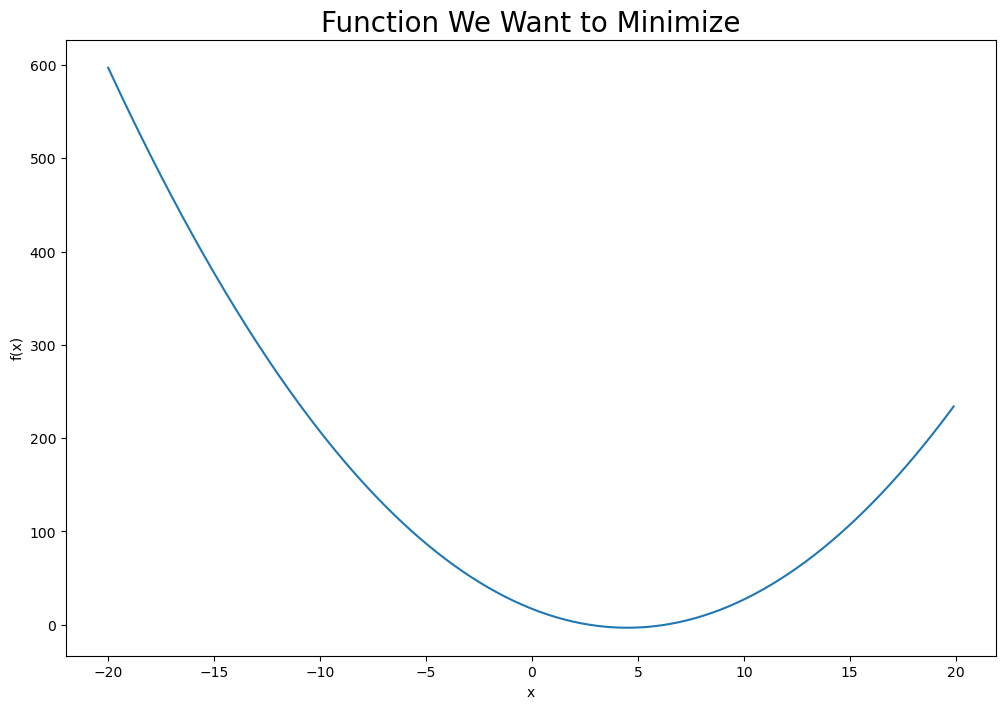

In [18]:
x_range = np.arange(-20, 20, .1)
y = f(x_range)

fig, ax = plt.subplots(figsize=(12, 8))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function We Want to Minimize", fontsize=20)
plt.plot(x_range, y);

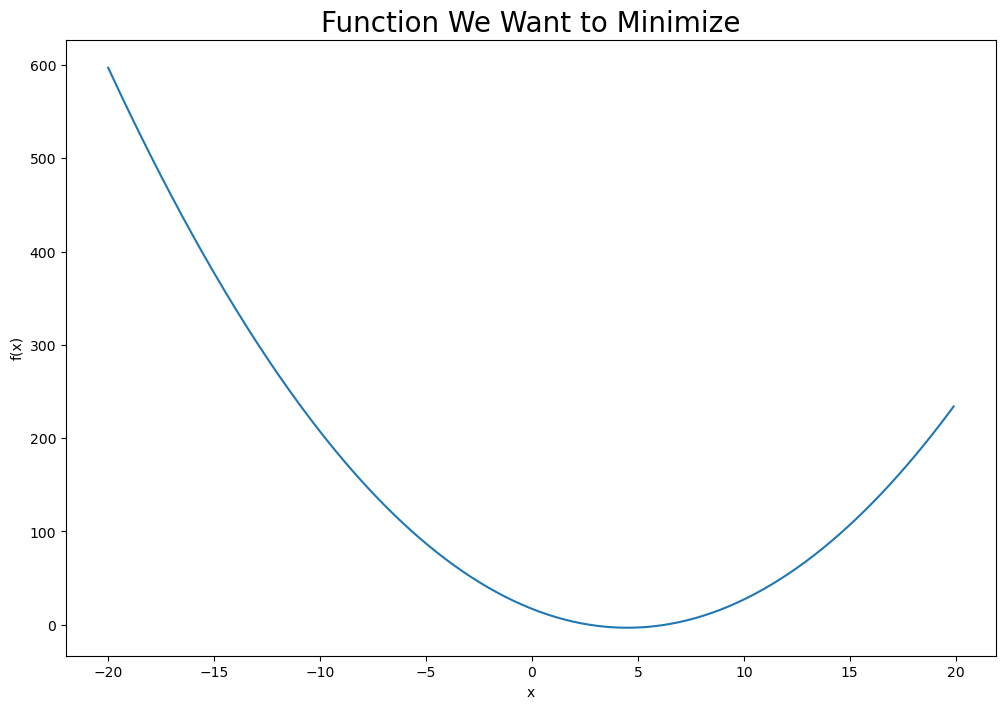

In [19]:
x_range = np.arange(-20, 20, .1)
y = f(x_range)

fig, ax = plt.subplots(figsize=(12, 8))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Function We Want to Minimize", fontsize=20)
plt.plot(x_range, y);

In [20]:
# initialize random start point
initial_x = np.random.randint(-20, 20)

# initialize previous step size
prev_step_size = 1

# Step size
gamma = .01

# Precision for convergence
precision = 0.0001  

# Max number of iterations
max_iters = 10000  

# Step counter
iters = 0

curr_x = initial_x

while prev_step_size > precision and iters < max_iters:
    prev_x = curr_x 
    curr_x = curr_x - gamma * df(prev_x) 
    prev_step_size = abs(curr_x - prev_x)
    iters = iters + 1 
    #print("Iteration", iters, "\nX value is", curr_x) 
    
print("")
print("Our random start point was", initial_x)
print("There was convergence after", iters, "steps")
print("The global minimum occurs at", curr_x)


Our random start point was 15
There was convergence after 380 steps
The global minimum occurs at 4.504865170471859


Awesome! In the example above traditional gradient descent appears to have performed well for us because our function $f(x)$ is strictly convex. In fact there are a number of reasons why gradient descent may not work well, can you think of some? In practice, there are a number of [variations](https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3) of the basic gradient descent algorithm above that are used.

Now back to our Lasso Model!!!

In [21]:
from sklearn.linear_model import Lasso

lambda_lasso = 10

lasso_model = Lasso(alpha=lambda_lasso, fit_intercept=False)
lasso_model.fit(x_train, y_train)
lasso_prediction = lasso_model.predict(x_validation)


lasso_loss = mean_squared_error(y_validation, lasso_prediction)
lasso_r2 = r2_score(y_validation, lasso_prediction)


print("Mean Squared Error of Linear Model: {:.2f}".format(linear_loss))
print("Mean Squared Error of Ridge Model: {:.2f}".format(ridge_loss))
print("Mean Squared Error of LASSO Model: {:.2f}".format(lasso_loss))
print("R2 of Linear Model: {:.2f}".format(lin_r2))
print("R2 of Ridge Model: {:.2f}".format(ridge_r2))
print("R2 of Lasso Model: {:.2f}".format(lasso_r2))

Root Mean Squared Error of Linear Model: 19.45
Root Mean Squared Error of Ridge Model: 19.26
Root Mean Squared Error of LASSO Model: 31.79
R2 of Linear Model: 0.67
R2 of Ridge Model: 0.67
R2 of Lasso Model: 0.45


In [22]:
print(linear_model.coef_, linear_model.intercept_)

[[-3.94690994e-07  4.65973718e-04 -2.04620495e-01  4.62278341e+01]] 0.0


In [23]:
print(ridge_model.coef_, ridge_model.intercept_)

[[-1.60131364e-07  2.86265257e-04 -1.63506015e-01  4.35764212e+01]] 0.0


In [24]:
print(lasso_model.coef_, lasso_model.intercept_)

[ 3.51030187e-06 -2.56237769e-03  4.98760520e-01  0.00000000e+00] 0.0


As we can see, currently the **LASSO Regression** does not have a great mse values due to the poor lambda values, but using **LASSO and Ridge**, we want to minimized the tloss of our linear regression models, so maybe penalizing some features allowed us to prevent overfitting on our dataset!

In practice, we always use Ridge or LASSO Regression over ordinary least squares.

##### <a id='norm-balls'></a>
### Derivatives and Sparsity

Let's take at another visualization that may help build some intuition behind how both of these regularization methods work!

<img src='bvdiff.JPG' width=400/>

The above plot is of the ridge regression penalty in blue and the LASSO in red. Note that when the values are small, the LASSO penalty is actually higher than the ridge penalty.


**Question**: Based on these visualizations, could you explain why LASSO is sparsity-inducing?

For a more mathematical motivation, consider the derivative of the LASSO and ridge penalties. 

$$\frac{\partial}{\partial w} w^2 = 2w$$
$$\frac{\partial}{\partial w} |w| = sign(w)$$

Recall that gradient descent algorithms go along the derivative of the loss. When we train a neural network to minimize these penalties, a network trained on LASSO will reduce the penalty to 0 (when possible) as the derivative is always 1. However, with the ridge penalty, the loss will essentailly "flatten out" when w approaches zero, and the network will pick a value for w that is close to zero, but not quite zero.

<img src='lassovsridge.JPG' width=600/>

Results from an emperical statement.


<a id='regularization-and-bias-variance'></a>
## Regularization and Bias Variance
As we mentioned earlier, **bias** is the average linear squares loss term across multiple models of the same family (e.g. same degree polynomial) trained on separate datasets. **Variance** is the average variance of the weight vectors (coefficients) on your features. 

Without the regularization term, we’re just minimizing bias; the regularization term means we won’t get the lowest possible bias, but we’re exchanging that for some lower variance so that our model does better at generalizing to data points outside of our training data.

<a id='lambda'></a>
## Lambda

We said that $\lambda$ is how much we care about the regularization term, but what does that look like? Let's return to the polynomial example from last week, and see what the resulting models look like with different values of $\lambda$ given a degree 8 polynomial.

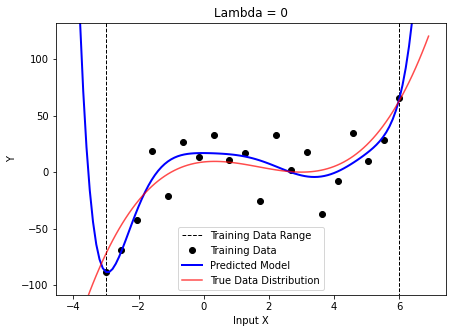

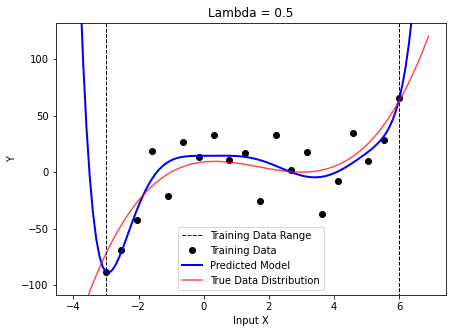

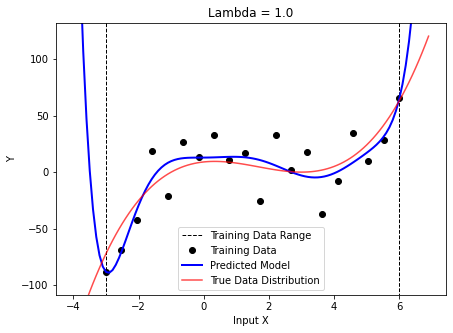

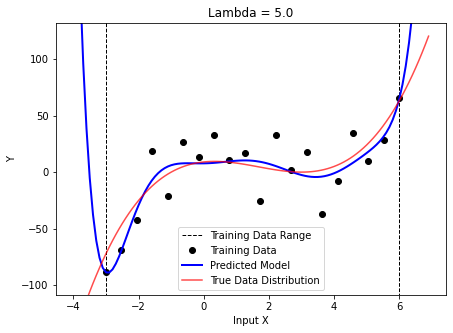

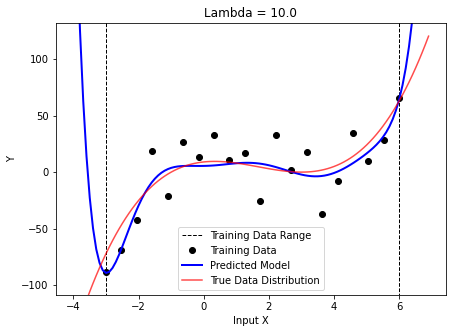

In [180]:
ridgeRegularizationDemo([0, 0.5, 1.0, 5.0, 10.0], 8)

From the diagram above, it's difficult to determine which lambda value help fit our model the closest to the true data distribution. So, **how do we know what to use for $\lambda$ (or `alpha` in the `sklearn.linear_model` constructors)?**

That's right, let's use the process of **validation** here! In this case, we'd be finding the value for lambda that **minimizes the loss for ridge regression, and then the one that minimizes the loss for LASSO regression**!

<a id='validation-on-lambda'></a>
## Validation on Lambda
Let's try to find the best $\lambda$ for the degree 20 polynomial on `displacement` from above.

In [181]:
lambdas = np.arange(0, 200) # create a list of potential lambda values

# create a list containing the corresponding mean_squared_error for each lambda usinb both ridge and lasso regression
ridge_errors = [] 
lasso_errors = []

for l in lambdas:
    ... # create the model
    ... # fit the model
    ... # use the fitted model to predict
    ridge_errors.append(...) # compute and append the validation error
        
    ... # create the model
    ... # fit the model
    ... # use the fitted model to predict
    lasso_errors.append(...) # compute and append the validation error

# finds the index of the minimum value in each list
answer = ridge_errors.index(min(ridge_errors)), lasso_errors.index(min(lasso_errors))
answer

TypeError: '<' not supported between instances of 'ellipsis' and 'ellipsis'

As we can see from above, we've been able to determine which lambdas minimizes our ridge regression model and our LASSO regression model through validation by iterating through potential lambda values and finding the ones that minimize our loss for each model!

<a id='validation'></a>
# Validation

When we train machine learning models, we use three types of data, used for different purposes. <br>

### Training data
The data we use to train the model (typically around 80% of the data)

### Validation data
The data we use to fine tune the model and adjust hyperparameters (typically around 15% of the data)

### Test data
The data we use to evaluate the model's performance (only used once, typically around 5% of the data)


<img src="https://i.imgur.com/LLPNd4u.png" width=400px height=400px />





<img src="http://ethen8181.github.io/machine-learning/model_selection/img/kfolds.png" width=600 height=600 />



*tl;dr you train your dog classifier on 3 of your dogs and then test it out on your friend's 4 dogs. Don't ask why we have so many dogs*  


Cross-validation is a technique for evaluating ML models by training ML models on different subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern.  [Source](https://docs.aws.amazon.com/machine-learning/latest/dg/cross-validation.html)

---

Cross-validation is primarily a way of measuring the predictive performance of a statistical model. Every statistician knows that the model fit statistics are not a good guide to how well a model will predict: high 
$R^2$ does not necessarily mean a good model. It is easy to over-fit the data by including too many degrees of freedom and so inflate $R^2$ and other fit statistics. For example, in a simple polynomial regression I can just keep adding higher order terms and so get better and better fits to the data. But the predictions from the model on new data will usually get worse as higher order terms are added. [Source](https://robjhyndman.com/hyndsight/crossvalidation/)


<img src="https://i.stack.imgur.com/1QU0m.png" />
<img src="https://miro.medium.com/max/1554/1*-xAhQ9ULYqmNOxRU4e_MXQ.png" />


When we run cross validation we tend to see stagnant test error but consistently better train error, telling us that our model is really good at fitting our training dataset but not good at modeling the overall dataset.


**Question**
What could you say is happening in each of these scenarios? {overfitting, underfitting, good model}
#### high training error, high validation error
#### low training error, high validation error
#### low training error, low validation error

<a id='conclusion'></a>
# Conclusion

Through the course of the notebook, we introduced the main idea of **ordinary least squares**, **regularizatiion**, and **validation**. Through **ordinary least squares**, we observed the intuition behind how models, such as the linear regression model creates the best possible fit. We also went into different methods we can use to minimize overfitting our model, and in turn lower variance, by taking look at a process called **regularization**. We saw that the two main regression models, **ridge regression** and **LASSO regression**, and saw the difference between the two (ridge -> penalize large weights, LASSO -> make weights sparse). We also took a look at different visualizations between the two to build up some more intuition behind how they work, through **graphs** and **derivatives**. Finally, we went through a familiar process (**validation**) to determine what the best values of lambda were for our models, officially ending our journey in this lecture!

# Congratulations! 

<a id='exercises'></a>
## Exercises

1. What happens as $\lambda$ increases?
    1. bias increases, variance increases
    2. bias increases, variance decreases
    3. bias decreases, variance increases
    4. bias decreases, variance decreases

**Insert answer here**:

2. For each of the following, choose **ridge**, **lasso**, **both**, or **neither**:
    1. L1-norm
    2. L2-norm
    3. Induces sparsity
    4. Has analytic (mathematical) solution
    5. Increases bias
    6. Increases variance

**Insert answer here:**

3. Which one is better to use: Ridge Regression or LASSO Regression?

**Insert answer here:**

### Congrats! You've finished our few conceptual questions and learned about Ordinary Least Squares, Regularization, and Validation!